In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
import time
import seaborn as sns

In [6]:
def scroll(driver, timeout, loops):
    scroll_pause_time = timeout

    last_height = driver.execute_script("return document.body.scrollHeight")
    num = 0
    
    while True and num < loops:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        num = num + 1
        time.sleep(scroll_pause_time)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

In [7]:
url = 'https://www.vivino.com/explore?e=eJwdijsOgCAQBW_zaqDfzo4jGGPWFQmJgAH83V5iM1PMxEIaMSRSiPyQ0UpBXhospMPi6NlvdHEJrvGOvFDhFpKvs-QzNWRaXRXcbZz6-st8itQcHw%3D%3D'
product_names = []
profile = webdriver.FirefoxProfile()
profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
options = Options()
options.headless = True
browser = webdriver.Firefox(options=options)
options.add_argument("start-maximized")
options.add_argument('disable-infobars')
browser.get(url)

loops = 150
timeout = 3
scroll(browser, timeout, loops)

titles = browser.find_elements_by_class_name('vintageTitle__wine--U7t9G')
prices = browser.find_elements_by_xpath("(//*[contains(@class, 'addToCartButton__price')])")
ratings = browser.find_elements_by_class_name('vivinoRating__averageValue--3Navj')
reviews = browser.find_elements_by_class_name('vivinoRating__caption--3tZeS')
countries = browser.find_elements_by_xpath('//a[contains(@href, "/explore?country_code")]')
#for price in prices:
#    print('price:',price.text)
for title, price, rating, review, country in zip(titles, prices, ratings, reviews, countries):
    with open('vinData.csv', 'a', encoding='UTF8') as f:
        writer = csv.writer(f)
        date = 9999
        line = re.findall(r'\d+', title.text)
        
        if(len(line)>0):
            for l in line:
                if(len(str(l)) == 4):
                    date = l
                    
        data = [title.text, date, price.text.split("\n", 1)[0], rating.text, review.text.split(" ", 1)[0], country.text]
        writer.writerow(data)
                                

In [3]:
df = pd.read_csv('vinData.csv', names=["Name", "Year", "Price", "Rating", "Review", "Country"])
df.head()

,Name,Year,Price,Rating,Review,Country
0,Edizione Cinque Autoctoni,9999,149.00,4.3,57745,Italy
1,Malbec 2018,2018,59.95,3.8,16764,Argentina
2,Malbec 2016,2016,129.95,4.1,16137,Argentina
3,Cabernet Sauvignon 2016,2016,1245.00,4.6,13942,United States
4,Malbec 2013,2013,99.95,3.9,13271,Argentina


In [4]:
df.describe()

,Year,Price,Rating,Review
count,450.000000,450.000000,450.000000,450.000000
mean,2104.351111,286.519067,4.023111,3169.573333
std,837.767652,287.901398,0.264026,4447.897243
min,1986.000000,39.950000,3.300000,1109.000000
25%,2015.000000,129.950000,3.800000,1425.500000
50%,2016.000000,181.500000,4.000000,1980.500000
75%,2018.000000,305.000000,4.200000,3365.250000
max,9999.000000,1995.000000,4.700000,57754.000000


In [5]:
sorted_df = df.copy()
sorted_df.drop(sorted_df[df.Review < 1500].index, inplace=True)
print(sorted_df)

                            Name  Year    Price  Rating  Review        Country
0      Edizione Cinque Autoctoni  9999   149.00     4.3   57745          Italy
1                    Malbec 2018  2018    59.95     3.8   16764      Argentina
2                    Malbec 2016  2016   129.95     4.1   16137      Argentina
3        Cabernet Sauvignon 2016  2016  1245.00     4.6   13942  United States
4                    Malbec 2013  2013    99.95     3.9   13271      Argentina
..                           ...   ...      ...     ...     ...            ...
445              Pinot Noir 2019  2019    99.00     4.0    4070  United States
446   Scaia Rosso (Corvina) 2015  2015   112.50     3.8    4022          Italy
447  Pinot Grigio Valdadige 2016  2016   135.00     3.8    3981          Italy
448        Les Darons Rouge 2017  2017   250.00     3.8    3940         France
449      Cabernet Sauvignon 2015  2015   129.95     4.0    3939      Argentina

[316 rows x 6 columns]


Lowest rated:                Name  Year   Price  Rating  Review Country
314      Tinto N.V.  9999   39.95     3.3    1326   Spain
345  7 Fuentes 2017  2017  150.00     3.3    1237   Spain 

Highest rated:                                                  Name  Year   Price  Rating  \
20  Gran Enemigo Single Vineyard Gualtallary Caber...  2015  599.95     4.7   
35                              Malbec Argentino 2017  2017  625.00     4.7   
76  Gran Enemigo Single Vineyard Gualtallary Caber...  2016  599.95     4.7   

    Review    Country  
20    5610  Argentina  
35    4562  Argentina  
76    3067  Argentina  


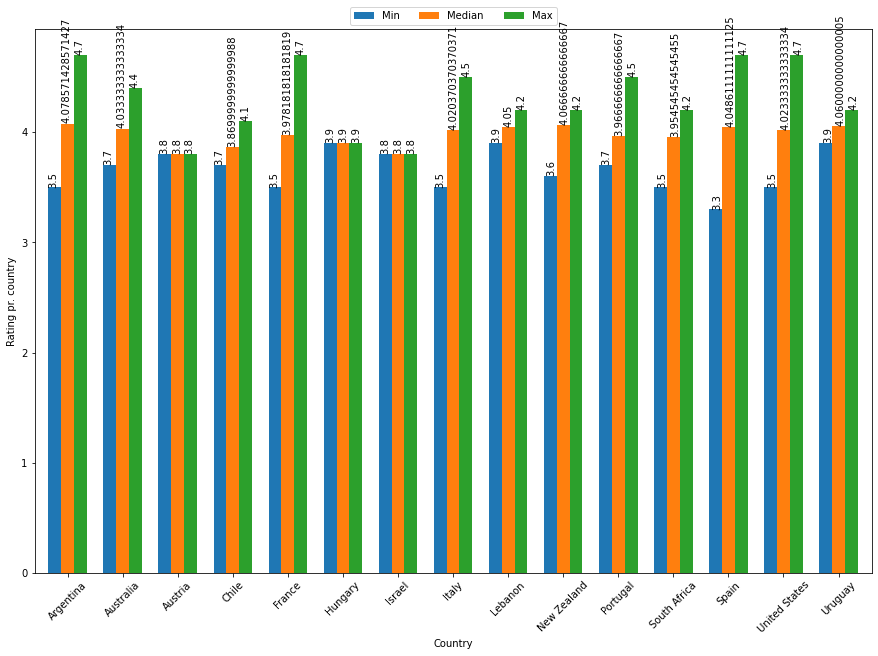

In [54]:
def plot_rating(df):
    
    all_lowest = df.loc[df['Rating'] == df['Rating'].min()]
    print('Lowest rated:',all_lowest[:3],'\n')
    #print('Median rating',df.mean(),'\n')
    
    all_highest = df.loc[df['Rating'] == df['Rating'].max()]
    print('Highest rated:',all_highest[:3])
    
    #Delete all with low review numbers
    sorted_df = df.copy()
    #sorted_df.drop(sorted_df[df.Review < 1500].index, inplace=True)
    
    #Extract Country & Rating columns
    cols = ['Country', 'Rating']
    mask = sorted_df[cols]
    
    #Group rows by Country
    mask_by_country = mask.groupby('Country')
    
    #Get Min, Median & Max rating for each country
    min_rating = mask_by_country.min()
    median_rating = mask_by_country.mean()
    max_rating = mask_by_country.max()
    
    df_stats = pd.DataFrame()
    df_stats['Min'] = min_rating['Rating']
    df_stats['Median'] = median_rating['Rating']
    df_stats['Max'] = max_rating['Rating']
    ax = df_stats.plot(kind='bar', figsize=(15,10), width=0.7)
    plt.xticks(rotation=45)
    plt.xlabel('Country')
    plt.ylabel('Rating pr. country');
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
    
    #Data on each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, (p.get_height()) * 1.005), rotation=90)
    
def describe(df):
    return df.describe()

plotbar = df.copy()
plot_rating(plotbar)

In [41]:
cols = ['Country', 'Rating']
mask = df[cols]
mask.info()
mask

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  450 non-null    object 
 1   Rating   450 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.2+ KB


,Country,Rating
0,Italy,4.3
1,Argentina,3.8
2,Argentina,4.1
3,United States,4.6
4,Argentina,3.9
...,...,...
445,United States,4.0
446,Italy,3.8
447,Italy,3.8
448,France,3.8


In [57]:
def describe_df(mask):
    mask_by_country = mask.groupby('Country')
    print(type(mask_by_country))
    return mask_by_country.describe()
describe_df(mask)

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


Rating                                                  
               count      mean       std  min    25%   50%    75%  max
Country                                                               
Argentina       70.0  4.078571  0.317551  3.5  3.800  4.05  4.200  4.7
Australia        6.0  4.033333  0.225093  3.7  4.000  4.00  4.075  4.4
Austria          1.0  3.800000       NaN  3.8  3.800  3.80  3.800  3.8
Chile           10.0  3.870000  0.125167  3.7  3.800  3.80  3.975  4.1
France          55.0  3.978182  0.299191  3.5  3.700  4.00  4.200  4.7
Hungary          1.0  3.900000       NaN  3.9  3.900  3.90  3.900  3.9
Israel           1.0  3.800000       NaN  3.8  3.800  3.80  3.800  3.8
Italy          108.0  4.020370  0.213454  3.5  3.900  4.00  4.200  4.5
Lebanon          2.0  4.050000  0.212132  3.9  3.975  4.05  4.125  4.2
New Zealand      6.0  4.066667  0.233809  3.6  4.100  4.15  4.200  4.2
Portugal        12.0  3.966667  0.214617  3.7  3.875  3.95  4.025  4.5
South Africa    11.0  3.954545  0.258316  3.5  3.750  4.10  4.200  4.2
Spain           72.0  4.048611  0.280840  3.3  3.875  4.10  4.200  4.7
United States   90.0  4.023333  0.264809  3.5  3.800  4.00  4.175  4.7
Uruguay          5.0  4.060000  0.134164  3.9  4.000  4.00  4.200  4.2

In [85]:
mask_by_country = mask.groupby('Country')
min_rating = mask_by_country.min()
median_rating = mask_by_country.mean()
max_rating = mask_by_country.max()
median_rating

,Rating
Country,
Argentina,4.078571
Australia,4.033333
Austria,3.800000
Chile,3.870000
France,3.978182
Hungary,3.900000
Israel,3.800000
Italy,4.020370
Lebanon,4.050000


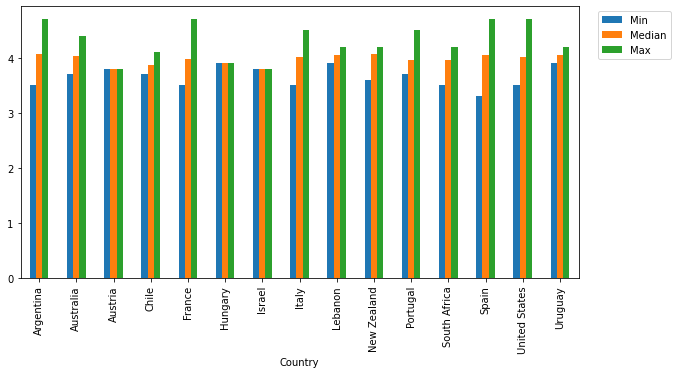

In [44]:
newdf = pd.DataFrame()

newdf['Min'] = min_rating['Rating']
newdf['Median'] = median_rating['Rating']
newdf['Max'] = max_rating['Rating']
newdf.plot(kind='bar', figsize=(10,5))
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1), ncol=1)

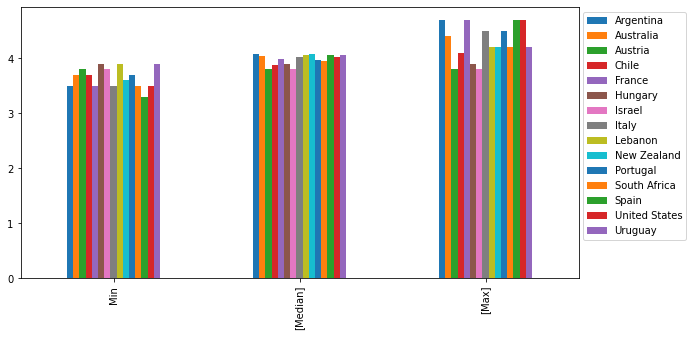

In [86]:
mydata = [min_rating['Rating'], median_rating['Rating'], max_rating['Rating']]
headers = ['Min', ['Median'], ['Max']]
newdf = pd.DataFrame(mydata, headers)
newdf.plot(kind='bar', figsize=(10,5))
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1), ncol=1)

In [46]:
median_rating.idxmax()

Rating    Argentina
dtype: object

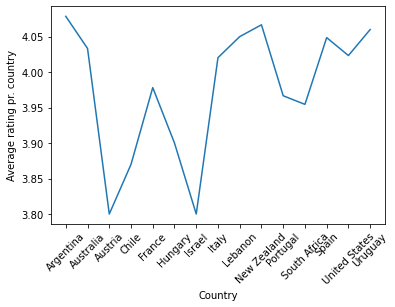

In [77]:
plt.plot(median_rating.index, median_rating)
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Average rating pr. country');

In [13]:
def plot_red(red_df):
    #red_df = pd.read_csv('redwinedata.csv', names=["Name", "Year", "Price", "Rating", "Review", "Country"])
    red_df.drop(red_df[red_df.Review < 112].index, inplace=False)
    return plot_rating(red_df)
red_df = pd.read_csv('redwinedata.csv', names=["Name", "Year", "Price", "Rating", "Review", "Country"])
plot_red(red_df)

NameError: name 'pd' is not defined

In [10]:
def plot_white(white_df):
    #white_df = pd.read_csv('whitewinedata.csv', names=["Name", "Year", "Price", "Rating", "Review", "Country"])
    white_df.drop(white_df[white_df.Review < 65].index, inplace=False)
    return plot_rating(white_df)
#white_df = pd.read_csv('whitewinedata.csv', names=["Name", "Year", "Price", "Rating", "Review", "Country"])
#plot_white(white_df)

In [11]:
def plot_sparkling(sparkling_df):
    #sparkling_df = pd.read_csv('sparklingwinedata.csv', names=["Name", "Year", "Price", "Rating", "Review", "Country"])
    sparkling_df.drop(sparkling_df[sparkling_df.Review < 95].index, inplace=False)
    return plot_rating(sparkling_df)
#sparkling_df = pd.read_csv('sparklingwinedata.csv', names=["Name", "Year", "Price", "Rating", "Review", "Country"])
#plot_sparkling(sparkling_df)